In [1]:
import os
os.chdir('./')

!crunch setup --notebook causality-discovery default --token YhGpBcTfpYTnB7oswUQ9W0WiFluMco8FwA8BmeRFk0FUWomiys2eC2h7JEF901y0


---
Your token seems to have expired or is invalid.

Please follow this link to copy and paste your new setup command:
https://hub.crunchdao.com/competitions/causality-discovery/submit

If you think that is an error, please contact an administrator.


In [1]:
"""
This is a basic example of what you need to do to enter the competition.
The code will not have access to the internet (or any socket related operation).
"""

import os
import typing

import castle.algorithms
import joblib
import networkx as nx
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import utils 

# keep me, I am needed by castle
import torch

2024-10-20 22:22:28,575 - e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-10-20 22:22:28,938 - e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.
e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import crunch
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>


In [2]:
X_train = pd.read_pickle('data/X_train.pickle')
X_test = pd.read_pickle('data/X_test.pickle')
y_train = pd.read_pickle('data/y_train.pickle')
y_test = pd.read_pickle('data/y_test.pickle')

In [4]:
# 显示数据基本信息
print("X_train keys:", X_train.keys())
print("X_test keys:", X_test.keys())
print("y_train keys:", y_train.keys() if isinstance(y_train, dict) else "y_train is not a dict")
print("y_test keys:", y_test.keys() if isinstance(y_test, dict) else "y_test is not a dict")

# 选择一个键来分析（假设 'data' 是主要的数据键）
key = '00000'  # 您可能需要根据实际情况调整这个键



X_train keys: dict_keys(['00000', '00002', '00007', '00009', '00011', '00016', '00017', '00018', '00024', '00028', '00030', '00038', '00039', '00041', '00043', '00044', '00045', '00047', '00048', '00050', '00053', '00054', '00056', '00059', '00060', '00061', '00065', '00067', '00069', '00070', '00073', '00074', '00076', '00080', '00081', '00082', '00083', '00084', '00086', '00088', '00091', '00093', '00096', '00098', '00100', '00101', '00103', '00105', '00106', '00108', '00109', '00111', '00112', '00114', '00115', '00119', '00123', '00125', '00128', '00129', '00135', '00136', '00138', '00140', '00141', '00142', '00143', '00144', '00145', '00147', '00148', '00149', '00151', '00152', '00153', '00157', '00158', '00159', '00161', '00162', '00166', '00167', '00168', '00169', '00171', '00176', '00177', '00187', '00188', '00190', '00191', '00195', '00196', '00199', '00204', '00207', '00208', '00210', '00212', '00215', '00217', '00222', '00223', '00226', '00228', '00229', '00230', '00232', '00

In [4]:
# Calculate the average number of directed edges across all graphs
total_edges = 0
total_graphs = 0

for key in y_train.keys():
    B = y_train[key]  # adjacency matrix
    
    # Convert the adjacency matrix to a NumPy array for easier calculation
    adj_matrix = B.to_numpy()
    
    # Count the number of directed edges (sum of all elements in the adjacency matrix)
    edges = adj_matrix.sum()
    
    total_edges += edges
    total_graphs += 1

average_edges = total_edges / total_graphs

print(f"Average number of directed edges across all graphs: {average_edges:.6f}")

Average number of directed edges across all graphs: 11.205362


In [5]:
key = '00012'
print(X_test[key])
print(y_test[key])


         0      Y      X
0   -0.245 -0.245  0.851
1    0.791  0.791 -0.323
2    0.323  0.323  0.289
3   -0.727 -0.727 -0.727
4   -0.349 -0.349  0.457
..     ...    ...    ...
995  0.309  0.309  0.307
996  0.061  0.061  0.631
997 -0.399 -0.399  0.245
998  0.497  0.497  0.061
999 -0.257 -0.257  0.833

[1000 rows x 3 columns]
        0  Y  X
parent         
0       0  1  1
Y       0  0  0
X       0  1  0


In [6]:
test_key = '00012'
print(X_test[test_key])
print(y_test[test_key])

         0      Y      X
0   -0.245 -0.245  0.851
1    0.791  0.791 -0.323
2    0.323  0.323  0.289
3   -0.727 -0.727 -0.727
4   -0.349 -0.349  0.457
..     ...    ...    ...
995  0.309  0.309  0.307
996  0.061  0.061  0.631
997 -0.399 -0.399  0.245
998  0.497  0.497  0.061
999 -0.257 -0.257  0.833

[1000 rows x 3 columns]
        0  Y  X
parent         
0       0  1  1
Y       0  0  0
X       0  1  0


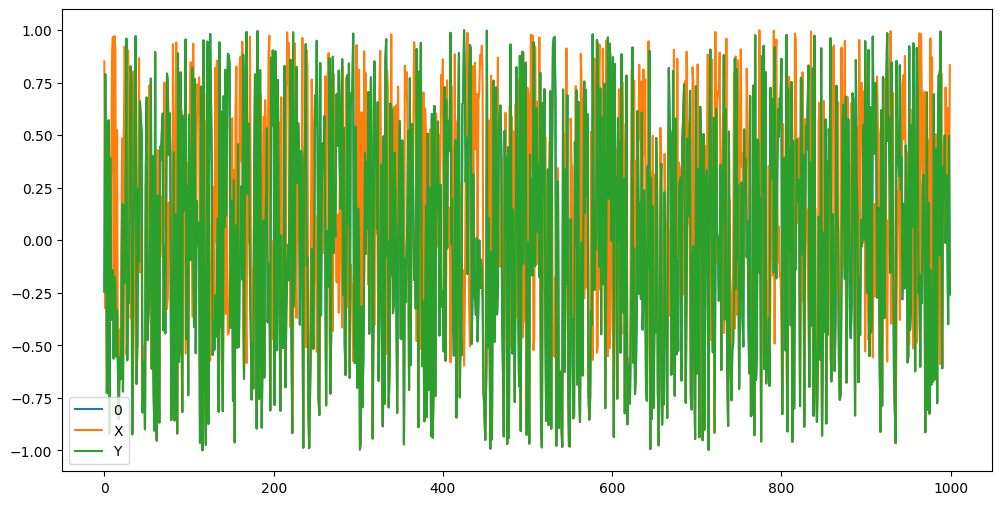

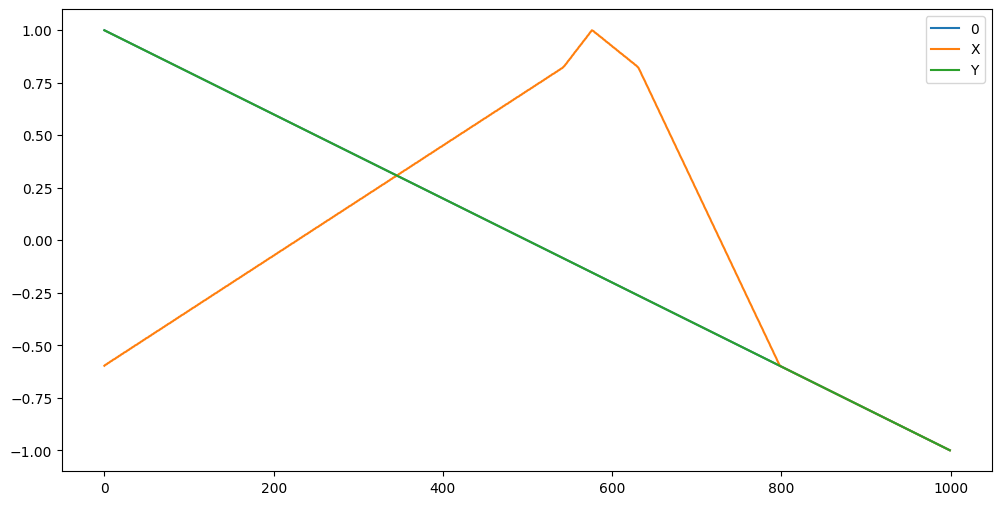

In [7]:
# 可视化，探索是否有时序关系

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(X_test[test_key]['0'], label='0')
plt.plot(X_test[test_key]['X'], label='X')
plt.plot(X_test[test_key]['Y'], label='Y')
plt.legend()
plt.show()

# sort by value of 0 and plot again
X_test_sorted = X_test[test_key].sort_values(by='0', ascending=False)
#reset index
X_test_sorted = X_test_sorted.reset_index()


plt.figure(figsize=(12, 6))
plt.plot(X_test_sorted['0'], label='0')
plt.plot(X_test_sorted['X'], label='X')
plt.plot(X_test_sorted['Y'], label='Y')
plt.legend()
plt.show()


In [16]:
# 对X进行简单的线性回归，然后再在图上展示
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression






425    0.999
452    0.997
181    0.995
988    0.993
168    0.991
       ...  
456   -0.991
645   -0.993
302   -0.995
714   -0.997
116   -0.999
Name: 0, Length: 1000, dtype: float64

In [8]:
graph_label, adjacency_label = utils.create_graph_label()

,0,1,X,Y
parent,,,,
0,0,0,1,0
1,0,0,0,0
X,0,1,0,1
Y,0,1,0,0


{'0': 'Cause of X', '1': 'Collider'}


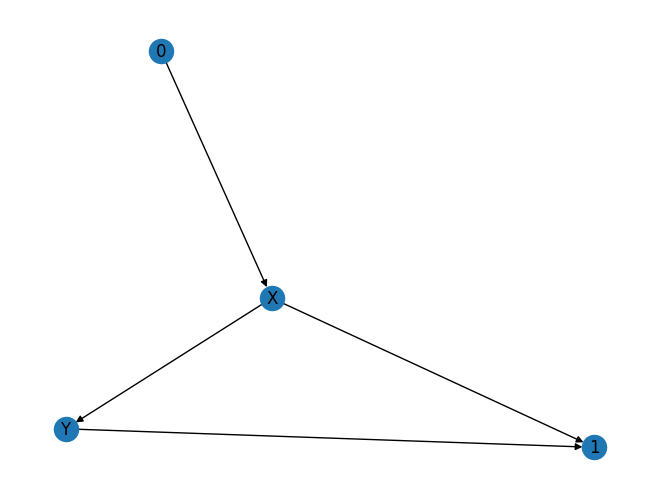

In [9]:
A = pd.DataFrame(
    data = {
        "0": [0, 0, 1, 0],
        "1": [0, 0, 0, 0],
        "X": [0, 1, 0, 1],
        "Y": [0, 1, 0, 0],
    },
    index = ["0", "1", "X", "Y"]
).T
A.index.name = "parent"
display(A)

g = nx.DiGraph(A)
nx.draw(g, with_labels=True)
print(utils.get_labels(A, adjacency_label))

In [17]:
print(utils.get_labels(y_train['00000'], adjacency_label))

{'0': 'Consequence of Y', '2': 'Independent', '3': 'Cause of Y', '4': 'Cause of Y', '5': 'Mediator', '6': 'Cause of Y', '7': 'Cause of Y', '8': 'Cause of X'}


In [23]:
# from collections import defaultdict

# # 使用 range 创建维度范围
# dimensions = range(3, 11)  # 3 到 10

# # 使用字典推导式创建 dimension_count_dict
# dimension_count_dict = {dim: 0 for dim in dimensions}

# # 定义所有可能的标签类型
# label_types = [
#     "Confounder", "Collider", "Mediator", "Cause of X", "Cause of Y",
#     "Consequence of X", "Consequence of Y", "Independent"
# ]

# # 使用 defaultdict 和字典推导式创建 dimension_label_type_dict
# dimension_label_type_dict = defaultdict(lambda: {label: 0 for label in label_types})


# for key in y_train:
#     causal_array = y_train[key]
#     dimension = len(causal_array)
#     dimension_count_dict[dimension] += 1
#     # 统计每个维度下的标签类型
#     label = utils.get_labels(y_train[key], adjacency_label)
#     for key, value in label.items():
#         dimension_label_type_dict[dimension][value] += 1
        
        
# print(dimension_label_type_dict)    

# print(dimension_count_dict)


# # save to json
# import json

# with open('dimension_label_type_dict.json', 'w') as f:
#     json.dump(dimension_label_type_dict, f)

# with open('dimension_count_dict.json', 'w') as f:
#     json.dump(dimension_count_dict, f)



defaultdict(<function <lambda> at 0x000002DFC0424AF0>, {10: {'Confounder': 2506, 'Collider': 1523, 'Mediator': 1569, 'Cause of X': 5920, 'Cause of Y': 14408, 'Consequence of X': 9779, 'Consequence of Y': 4016, 'Independent': 34007}, 8: {'Confounder': 1042, 'Collider': 632, 'Mediator': 782, 'Cause of X': 1253, 'Cause of Y': 2350, 'Consequence of X': 1960, 'Consequence of Y': 889, 'Independent': 3968}, 6: {'Confounder': 868, 'Collider': 524, 'Mediator': 635, 'Cause of X': 578, 'Cause of Y': 1014, 'Consequence of X': 1034, 'Consequence of Y': 465, 'Independent': 1190}, 5: {'Confounder': 843, 'Collider': 545, 'Mediator': 587, 'Cause of X': 387, 'Cause of Y': 652, 'Consequence of X': 649, 'Consequence of Y': 340, 'Independent': 569}, 9: {'Confounder': 1753, 'Collider': 1000, 'Mediator': 1209, 'Cause of X': 3024, 'Cause of Y': 6190, 'Consequence of X': 4559, 'Consequence of Y': 1868, 'Independent': 12982}, 7: {'Confounder': 953, 'Collider': 563, 'Mediator': 679, 'Cause of X': 891, 'Cause of 

C:\Users\Ori\AppData\Local\Temp\ipykernel_3060\1074834150.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(labels)))
2024-09-15 18:50:14,547 - e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\matplotlib\category.py[line:223] - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-15 18:50:14,551 - e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\matplotlib\category.py[line:223] - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-15 18:50:

2024-09-15 18:50:14,578 - e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\matplotlib\category.py[line:223] - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-15 18:50:14,591 - e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\matplotlib\category.py[line:223] - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-15 18:50:14,607 - e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\matplotlib\category.py[line:223] - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-15 18:50:14,620 - e:\Softwares\Anaconda\CondaEnvs\

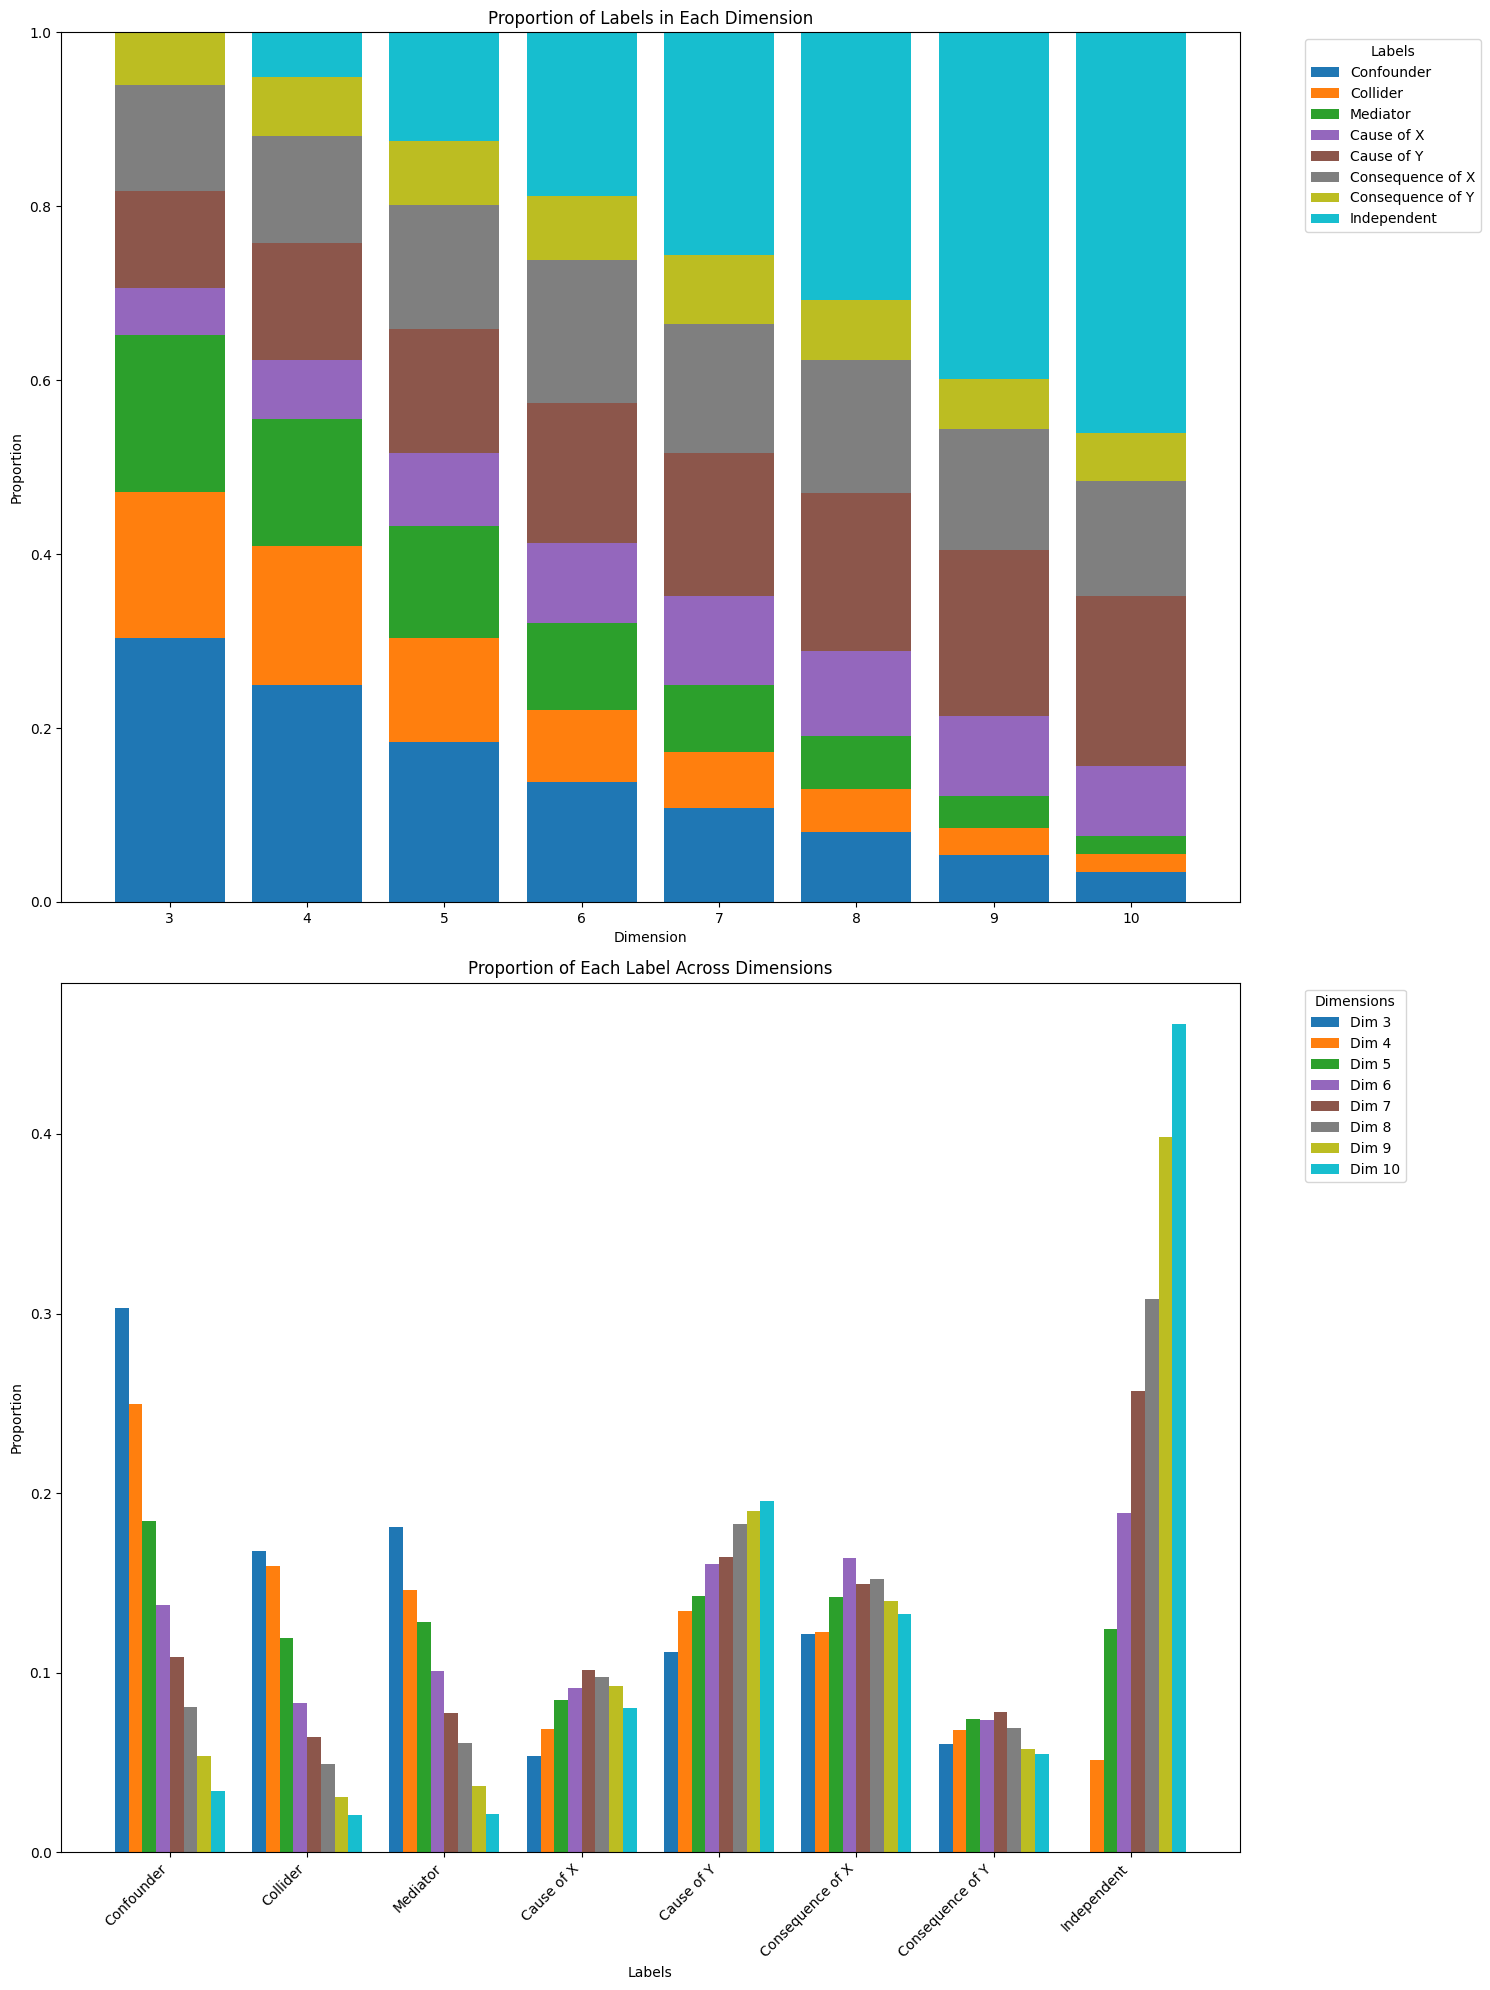

In [27]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 读取 dimension_label_type_dict.json
with open('dimension_label_type_dict.json', 'r') as f:
    dimension_label_type_dict = json.load(f)

# 转换数据结构
dimensions = sorted(dimension_label_type_dict.keys(), key=int)
labels = list(dimension_label_type_dict[dimensions[0]].keys())

# 创建数据矩阵
data = np.array([[dimension_label_type_dict[dim][label] for label in labels] for dim in dimensions])

# 计算每个维度的总数
totals = data.sum(axis=1)

# 计算比例
proportions = data / totals[:, np.newaxis]

# 设置颜色
colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(labels)))

# 创建堆叠条形图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

# 堆叠条形图：显示每个维度下label的比例
bottom = np.zeros(len(dimensions))
for i, label in enumerate(labels):
    ax1.bar(dimensions, proportions[:, i], bottom=bottom, label=label, color=colors[i])
    bottom += proportions[:, i]

ax1.set_title('Proportion of Labels in Each Dimension')
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Proportion')
ax1.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')

# 分组条形图：显示每个label在不同维度下的比例
x = np.arange(len(labels))
width = 0.1
for i, dim in enumerate(dimensions):
    ax2.bar(x + i*width, proportions[i, :], width, label=f'Dim {dim}', color=colors[i])

ax2.set_title('Proportion of Each Label Across Dimensions')
ax2.set_xlabel('Labels')
ax2.set_ylabel('Proportion')
ax2.set_xticks(x + width * (len(dimensions) - 1) / 2)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.legend(title='Dimensions', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 可选：保存图片
# plt.savefig('label_proportions.png', dpi=300, bbox_inches='tight')

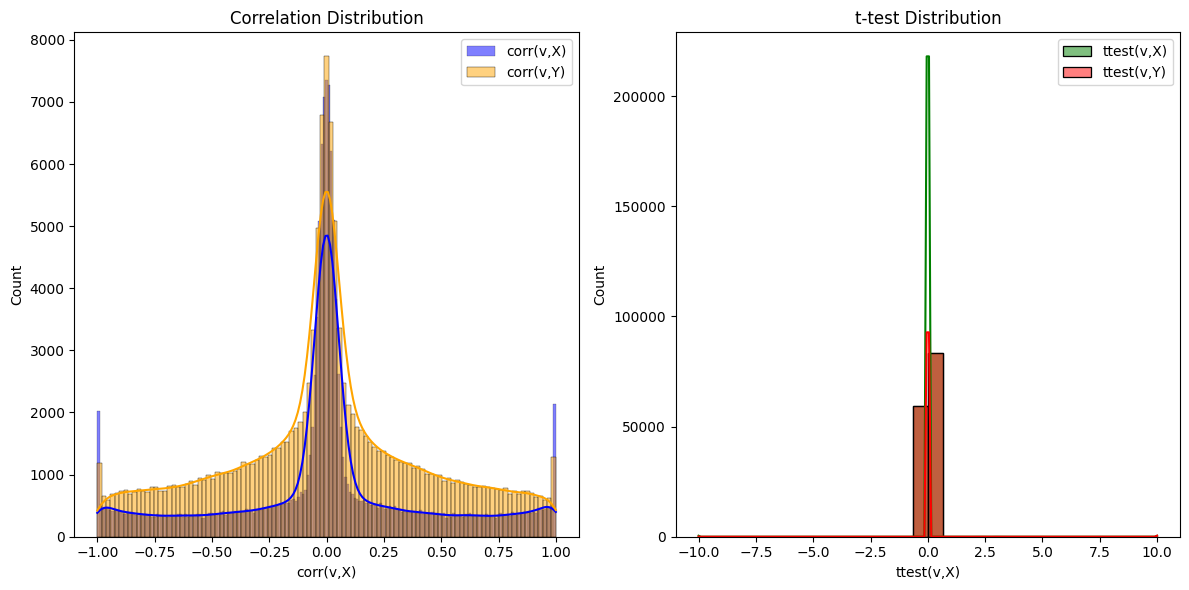

异常值行数： 207
        dataset  variable  dimension  corr(v,X)  corr(v,Y)  \
509         171         0          7   0.438107  -0.252169   
510         171         1          7  -0.030346   0.004556   
511         171         2          7  -0.017182   0.076631   
512         171         4          7   0.029353  -0.034093   
513         171         5          7   0.038045   0.505923   
...         ...       ...        ...        ...        ...   
138393    45545         7          7  -0.716933  -0.230901   
138394    45545         8          7   0.007989   0.008809   
139073    45759         0          8  -0.021937   0.146504   
139949    46050         3          2  -0.839810   0.839810   
140356    46185         3          2  -0.941424  -0.962397   

        max(corr(v, others))  min(corr(v, others))  mean(corr(v, others))  \
509                 0.648873              0.019337               0.357145   
510                 0.648873              0.004556               0.100720   
511          

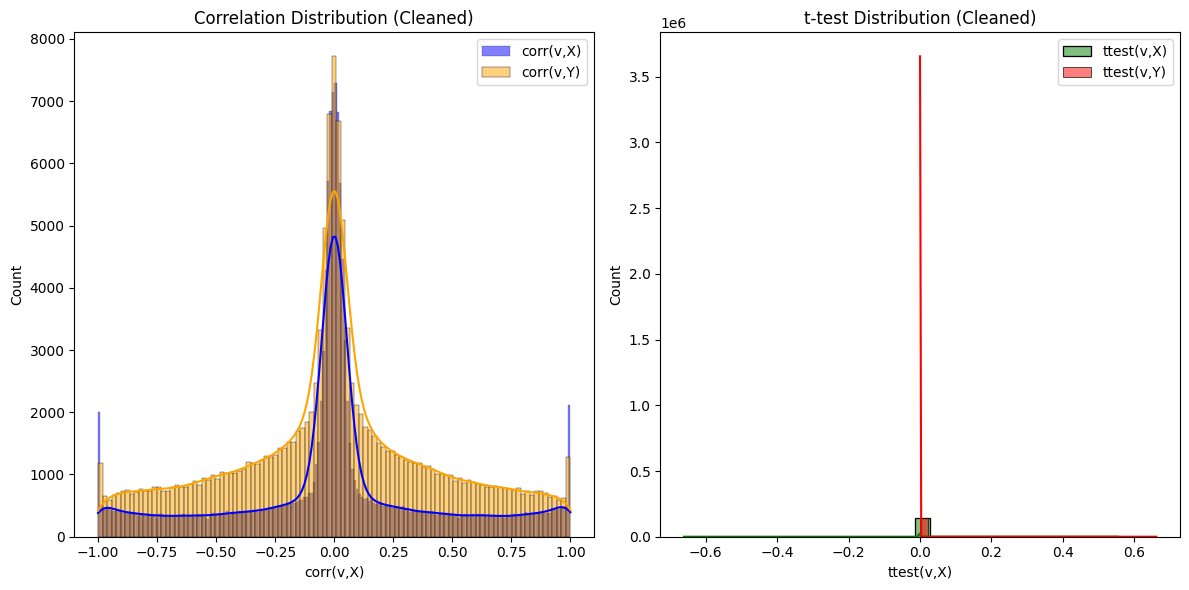

In [2]:
data_path = './X_y_group_train.csv'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 读取 CSV 文件
df = pd.read_csv(data_path)

# 可视化相关性和 t-test 结果的分布
# 为了防止范围过大，使用 clip 限制 ttest 的数值范围
df['ttest(v,X)'] = df['ttest(v,X)'].clip(lower=-10, upper=10)
df['ttest(v,Y)'] = df['ttest(v,Y)'].clip(lower=-10, upper=10)

# 可视化相关性和 t-test 结果的分布
plt.figure(figsize=(12, 6))

# 相关性分布
plt.subplot(1, 2, 1)
sns.histplot(df['corr(v,X)'], kde=True, color='blue', label='corr(v,X)')
sns.histplot(df['corr(v,Y)'], kde=True, color='orange', label='corr(v,Y)')
plt.legend()
plt.title('Correlation Distribution')

# t-test 结果的分布
plt.subplot(1, 2, 2)
sns.histplot(df['ttest(v,X)'], kde=True, color='green', label='ttest(v,X)', bins=30)  # 调整 bins
sns.histplot(df['ttest(v,Y)'], kde=True, color='red', label='ttest(v,Y)', bins=30)    # 调整 bins
plt.legend()
plt.title('t-test Distribution')

plt.tight_layout()
plt.show()

# 异常值检测：使用 Z 分数来检测异常值
z_scores = np.abs(stats.zscore(df[['corr(v,X)', 'corr(v,Y)', 'ttest(v,X)', 'ttest(v,Y)']]))
df['z_score_max'] = np.max(z_scores, axis=1)

# 定义异常值阈值
threshold = 3

# 标记异常值
df['is_outlier'] = df['z_score_max'] > threshold

# 打印异常值的行
outliers = df[df['is_outlier']]
print("异常值行数：", outliers.shape[0])
print(outliers)

# 清洗异常值：去除异常值
df_cleaned = df[df['is_outlier'] == False].copy()

# 清洗后的数据保存
df_cleaned.to_csv('cleaned_data.csv', index=False)

# 可视化清洗后的数据分布
plt.figure(figsize=(12, 6))

# 相关性分布（清洗后）
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['corr(v,X)'], kde=True, color='blue', label='corr(v,X)')
sns.histplot(df_cleaned['corr(v,Y)'], kde=True, color='orange', label='corr(v,Y)')
plt.legend()
plt.title('Correlation Distribution (Cleaned)')

# t-test 结果的分布（清洗后）
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['ttest(v,X)'], kde=True, color='green', label='ttest(v,X)', bins=30)
sns.histplot(df_cleaned['ttest(v,Y)'], kde=True, color='red', label='ttest(v,Y)', bins=30)
plt.legend()
plt.title('t-test Distribution (Cleaned)')

plt.tight_layout()
plt.show()


In [6]:
# df_cleaned.to_csv('./X_y_group_train_cleaned.csv')

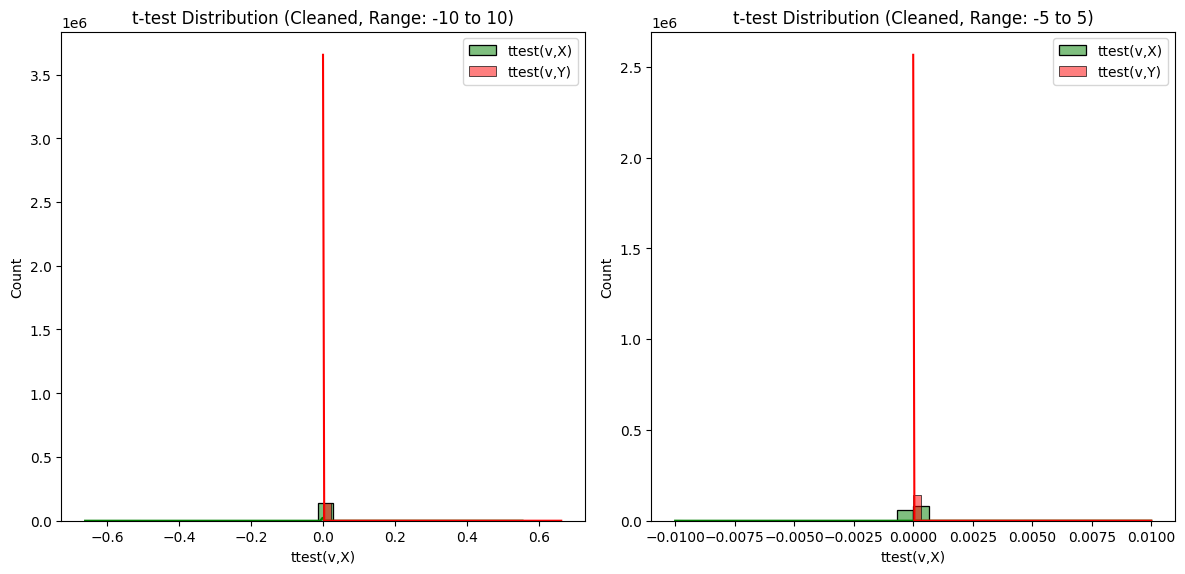

In [7]:
# 在更小的范围内展示ttest的结果
plt.figure(figsize=(12, 6))

# t-test 结果的分布（清洗后，缩小范围）
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['ttest(v,X)'].clip(-10, 10), kde=True, color='green', label='ttest(v,X)', bins=30)
sns.histplot(df_cleaned['ttest(v,Y)'].clip(-10, 10), kde=True, color='red', label='ttest(v,Y)', bins=30)
plt.legend()
plt.title('t-test Distribution (Cleaned, Range: -10 to 10)')

# 进一步缩小范围
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['ttest(v,X)'].clip(-0.01, 0.01), kde=True, color='green', label='ttest(v,X)', bins=30)
sns.histplot(df_cleaned['ttest(v,Y)'].clip(-0.01, 0.01), kde=True, color='red', label='ttest(v,Y)', bins=30)
plt.legend()
plt.title('t-test Distribution (Cleaned, Range: -5 to 5)')

plt.tight_layout()
plt.show()




In [2]:
import matplotlib.pyplot as plt
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

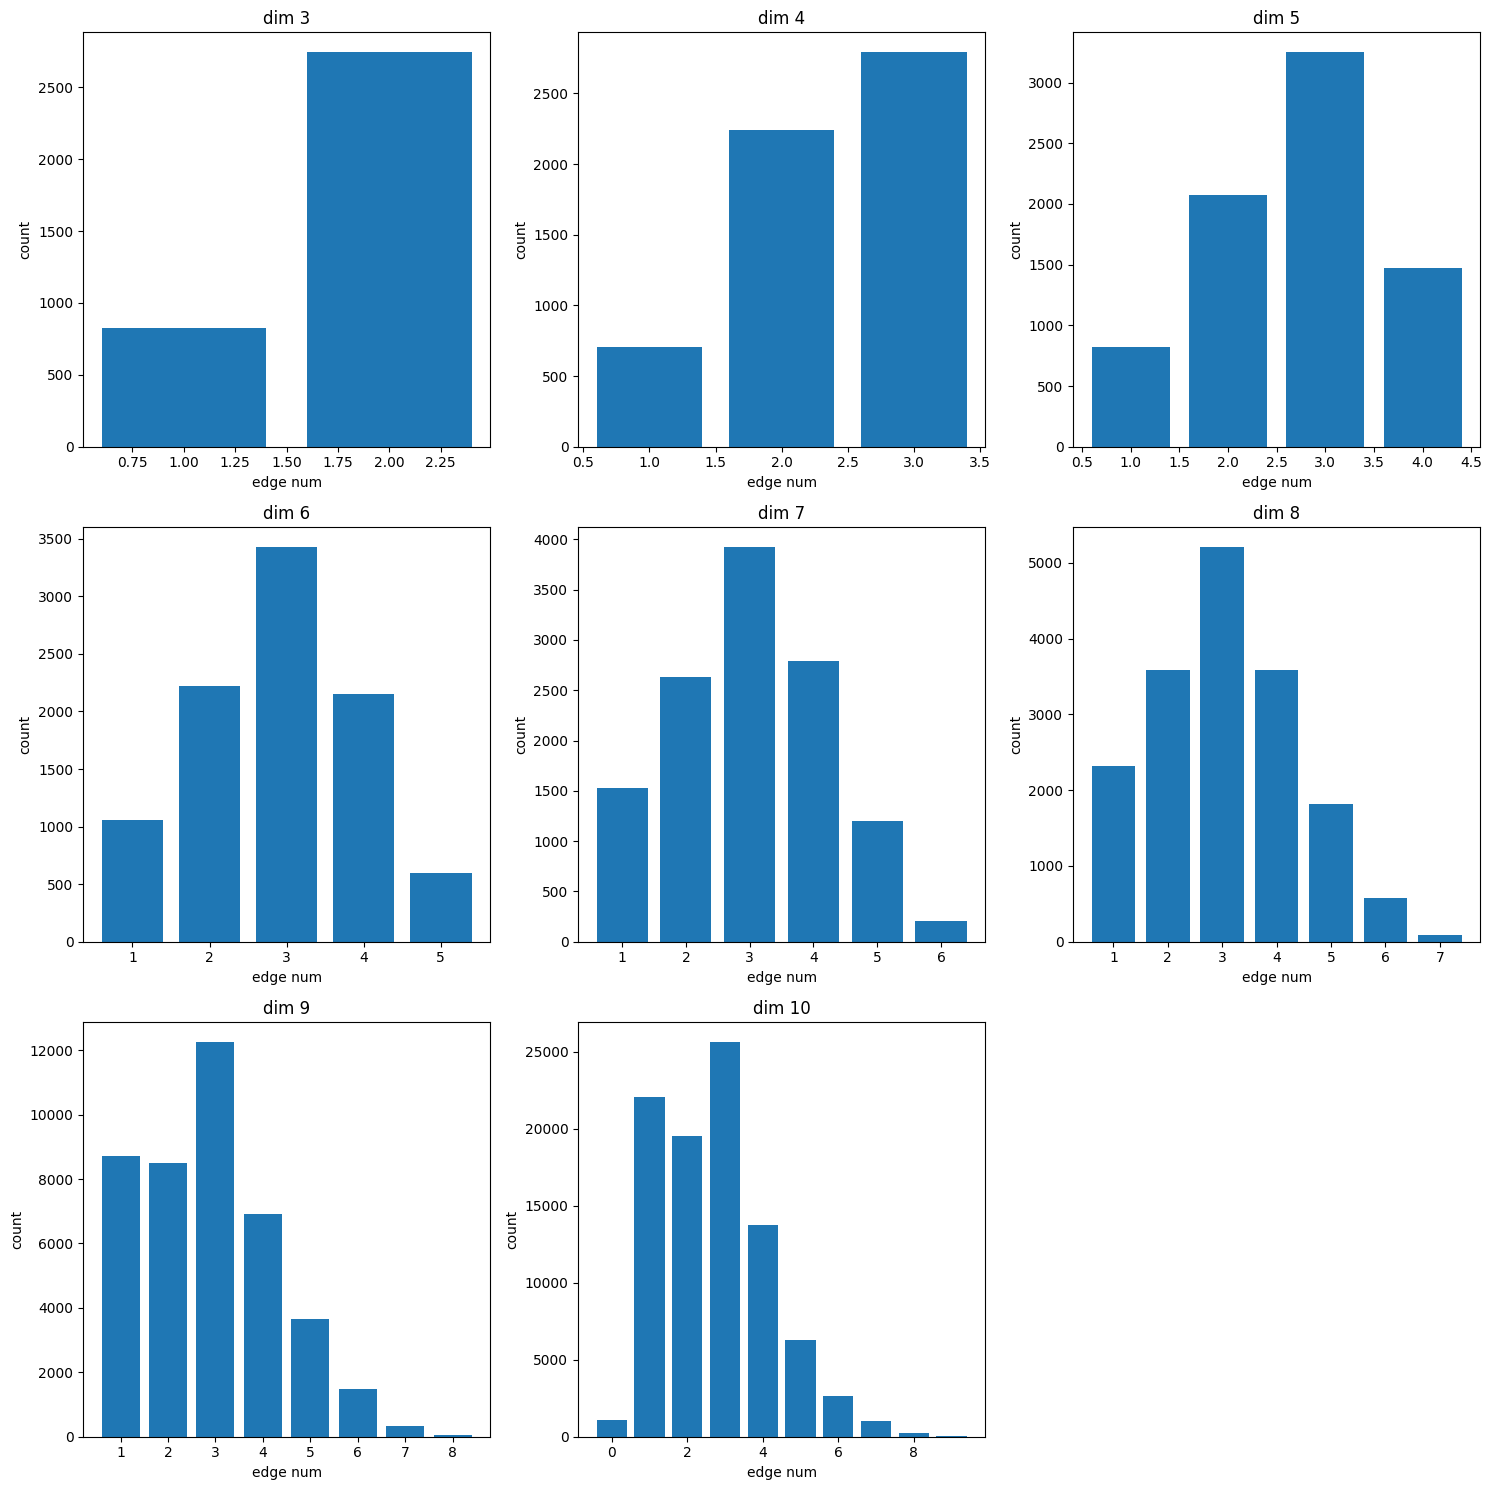

In [3]:
# 初始化一个字典，用于存储每个维度下的节点连接边数
edge_counts_by_dim = {}

# 遍历每个数据集
for key in y_train.keys():
    B = y_train[key]  # 邻接矩阵
    dim = B.shape[0]  # 数据集的维度，即节点数量

    # 如果该维度还没有在字典中，初始化一个列表
    if dim not in edge_counts_by_dim:
        edge_counts_by_dim[dim] = []

    # 将邻接矩阵转换为NumPy数组，方便计算
    adj_matrix = B.to_numpy()

    # 计算每个节点的出度（行求和）和入度（列求和）
    out_degree = adj_matrix.sum(axis=1)
    in_degree = adj_matrix.sum(axis=0)

    # 计算每个节点的总度数（连接的边数）
    total_degree = out_degree + in_degree

    # 将该数据集的节点度数添加到对应维度的列表中
    edge_counts_by_dim[dim].extend(total_degree)

# 绘制频次柱状图
import math

dims = sorted(edge_counts_by_dim.keys())  # 获取所有的维度，并排序

n_dims = len(dims)  # 总的维度数量

ncols = 3  # 每行显示的子图数量
nrows = math.ceil(n_dims / ncols)  # 需要的行数

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
axes = axes.flatten()  # 将axes数组展平，方便迭代

for i, dim in enumerate(dims):
    counts = edge_counts_by_dim[dim]  # 获取该维度下所有节点的度数
    ax = axes[i]

    # 绘制频次柱状图
    bins = range(int(min(counts)), int(max(counts)) + 2)  # 设置直方图的bins
    ax.hist(counts, bins=bins, align='left', rwidth=0.8)
    ax.set_title(f'dim {dim}')
    ax.set_xlabel('edge num')
    ax.set_ylabel('count')

# 如果有多余的子图，隐藏它们
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()